In this notebook, we plot user addition/attrition diagram, as per "Computation Methods For Dynamic Graphs", Cortes et. al.

Our data is a text file whose each line is of the following format:

>user1;user2;date;{Q1;...;Q2;P1;...;P2};msg

Here, fields, which are in the {}, are optional.

For example:

>Raoli;Torsolo;2012-10-30;Q1056;Ciao, tanto per capire come funziona ho preso una voce da Pedia e ho creato un elemento. Però su Wikidata si tratta semplicemente di inserire un elenco di link alle altre wikipedia. Di Wikiquote, source non c'è traccia. Per esempio in <b><a href="/wiki/Q1056" title="Q1056">Italo Balbo</a></b> ho aggiunto tutti i link e in 8 minuti ho fatto quello che potevo fare in 30 secondi. Ho dovuto copia-incollare tutti i link uno ad uno, apsettare che prendesse la lingua e aspettare che salvasse. Sai se c'è un modo per trasferirli in massa senza bot? Grazie <a href="/wiki/User:Raoli" title="User:Raoli">Raoli</a> (<a href="/wiki/User_talk:Raoli" title="User talk:Raoli">talk</a>) 21:33, 30 October 2012 (UTC)

In the following analysis, we take **all the communications** into account

# User Addition and Attrition Rate
Functions to compute node addition.

In [1]:
# pathToDataFile: path to the weekly communication in our dataset.
# return a list of set of users each week
def computeWeeklyUsers(pathToDataFile):
    f = open(pathToDataFile, 'r')
    users = []
    for l in f:
        items = l.split(";")
        users.append(items[0])
        users.append(items[1])
    return set(users)  

def computeListOfWeeklyUsers(filePrefix, numberOfWeeks):
    result = []
    for i in range(0,numberOfWeeks):
        result.append(computeWeeklyUsers(filePrefix + str(i)))
    return result
   
def computeListOfCummulativeWeeklyUsers(filePrefix, numberOfWeeks):
    weeklySetofUsers = computeListOfWeeklyUsers(filePrefix, numberOfWeeks)
    result = []
    cumul = set()
    for i in range(0, len(weeklySetofUsers)):
        cumul = cumul.union(weeklySetofUsers[i])
        result.append(cumul)
    return result


def computeNewUserSize(listOfCumulWeeklyUsers):
    result = []
    result.append(len(listOfCumulWeeklyUsers[0]))
    for i in range(1, len(listOfCumulWeeklyUsers)):
        result.append(len(listOfCumulWeeklyUsers[i]) - len(listOfCumulWeeklyUsers[i-1]))
    return result
    
# compute cummulative percent of unique users
# newUserSize: a list of number of unique users seen at each week
def computeCumulativePercentNodeAddition(filePrefix, numberOfWeeks):
    listOfCumulWeeklyUsers = computeListOfCummulativeWeeklyUsers(filePrefix, numberOfWeeks)
    newUserSize = computeNewUserSize(listOfCumulWeeklyUsers);
    cumulPercent = []
    for i in range(0,len(newUserSize)):
        cumulPercent.append(sum(newUserSize[0:i+1]))
    totalUser = sum(newUserSize)
    cumulPercent = [(x/totalUser)*100 for x in cumulPercent]
    return cumulPercent
        

Function to compute node attrition. How do we compute node attrition?

Node attrition = *The number of nodes that we see for the last time in week i*

U(i) = set of users seen in week i.
U(i+1,n) = set of users seen from week (i+1) till week n.
nodeAttrition = |U(i) - U(i+1),n)|

In [2]:
def setOfUsersFrom(startWeek, weeklyUserSet):
    if startWeek < 0 or startWeek > len(weeklyUserSet):
        raise ValueError
    result = set()
    for i in range(startWeek, len(weeklyUserSet)):
        result = result.union(weeklyUserSet[i])
    return result

def computeNodeAttritions(weeklyUserSet):
    attritions = []
    for i in range(0, len(weeklyUserSet)):
        a = len(weeklyUserSet[i] - setOfUsersFrom(i+1, weeklyUserSet))
        attritions.append(a)
    return attritions

def computeCumulativePercentNodeAttrition(nodeAttritions):
    total = sum(nodeAttritions)
    cumul = [sum(nodeAttritions[0:i]) for i in range(1,len(nodeAttritions)+1)]
    percent = [x*100/total for x in cumul]
    return percent





In [145]:
# cumulPercent: a list of cummulative percent of unique users seen at week i
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model

def plotAdditionLine(fromWeek, percent, color='green'):
    # train
    weeks_train = [w for w in range(fromWeek, len(percent))]
    weeks_train = np.array(weeks_train).reshape(len(weeks_train),1)
    regr = linear_model.LinearRegression()
    regr.fit(weeks_train, percent[fromWeek:])
    print(regr.coef_)
    
    # plot over the whole time
    weeks = [w for w in range(0,len(percent))]
    weeks = np.array(weeks).reshape(len(weeks),1)
    plt.plot(weeks, regr.predict(weeks), color=color, linewidth=2)

def plotAddAttr(additionPercent, attritionPercent):
    plt.plot([w for w in range(1, len(additionPercent) + 1)],additionPercent, 'g+')
    plt.plot([w for w in range(1, len(attritionPercent) + 1)],attritionPercent,'r^')
    plt.ylabel("Cummulative Percentage")
    plt.xlabel("Study Week Observed")
    
    # plot addition line
    plotAdditionLine(70, additionPercent, 'black')
    
    # plot attrition line
    plotAdditionLine(160, attritionPercent, 'black')
    
    
 

[ 0.27086265]
[ 0.47786325]


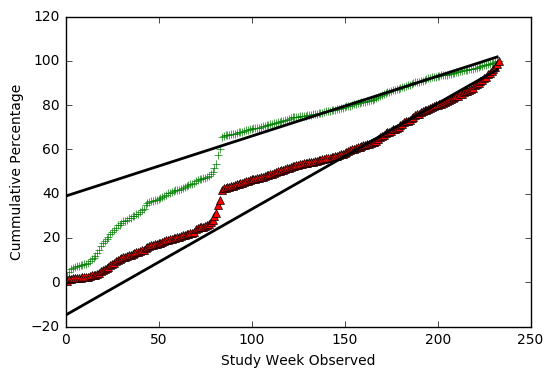

In [146]:
# node addition
additionPercent = computeCumulativePercentNodeAddition(filePrefix="../data/wtp-networksv2//wtpnetwork_timestamp.csv_", numberOfWeeks=233)

# node attrition
weeklyUserSet = computeListOfWeeklyUsers(filePrefix="../data/wtp-networksv2//wtpnetwork_timestamp.csv_", numberOfWeeks=233)
nodeAttrition = computeNodeAttritions(weeklyUserSet)
attritionPercent = computeCumulativePercentNodeAttrition(nodeAttrition)

# plot
plotAddAttr(additionPercent,attritionPercent)
plt.show()


The rate of loosing people is much higher than the rate of getting new contributors ((0.47786325/0.27086265)*100 = 176%)

# How many of these users are regular contributors?

We answer this question by plotting a bar chart number of contributing weeks versus number of contributors



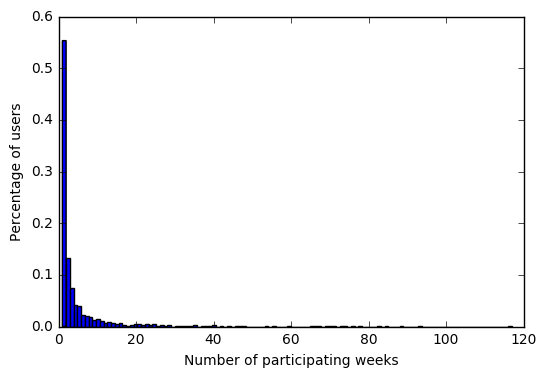

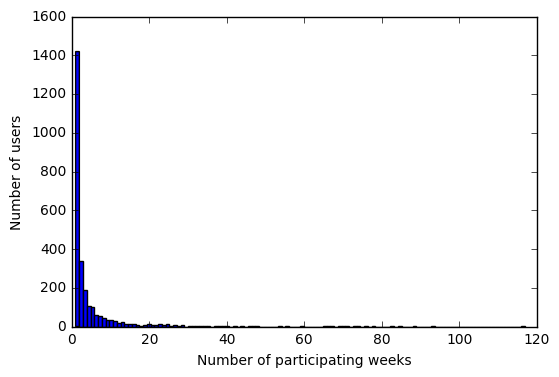

In [207]:
# user -> number of participating weeks
userToWeeks = dict()
weeklyUsers = computeListOfWeeklyUsers(filePrefix="../data/wtp-networksv2//wtpnetwork_timestamp.csv_", numberOfWeeks=233)
for week in weeklyUsers:
    for u in week:
        if (u in userToWeeks):
            userToWeeks[u] = userToWeeks[u] + 1
        else:
            userToWeeks[u] = 1

data = [v for (u,v) in userToWeeks.items()]
plt.hist(data,120, normed=True)
plt.xlabel("Number of participating weeks")
plt.ylabel("Percentage of users")
plt.show()
plt.hist(data,120, normed=False)
plt.xlabel("Number of participating weeks")
plt.ylabel("Number of users")
plt.show()







Ok let's filter out user that participate more than 10 week and see what happens

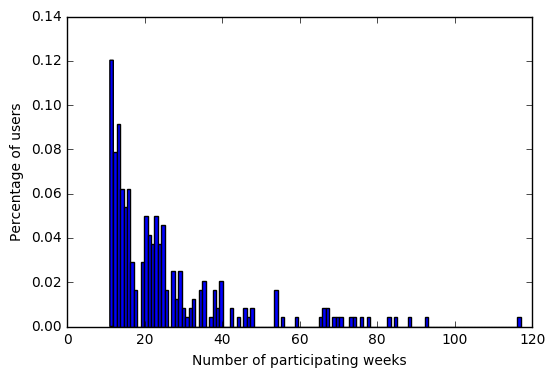

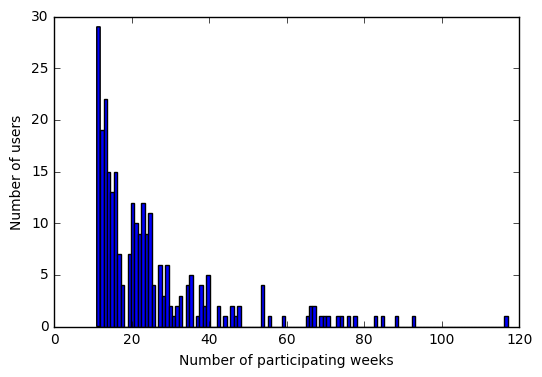

In [206]:
fdata = [i for i in data if i > 10]
plt.hist(fdata,120, normed=True)
plt.xlabel("Number of participating weeks")
plt.ylabel("Percentage of users")
plt.show()
plt.hist(fdata,120, normed=False)
plt.xlabel("Number of participating weeks")
plt.ylabel("Number of users")
plt.show()

# How many items do they mentions in their talks?

In [230]:
def getSetOfArtifacts(pathToDataFile):
    f = open(pathToDataFile, 'r')
    artifacts = []
    for l in f:
        items = l.split(";")
        if len(items) > 4:
            for i in range(3, len(items)-1):
                if items[i].startswith('P') or items[i].startswith('Q'):  # this is to remove wrong-formatted artifacts. Need to fix generating code.
                    artifacts.append(items[i])
    return set(artifacts)

def getAllSetOfArtifacts(filePrefix, numberOfWeeks):
    result = []
    for i in range(0, numberOfWeeks):
        result.append(getSetOfArtifacts(filePrefix + str(i)))
    return result


print(len(getSetOfArtifacts('/Users/totucuong-standard/Projects/wikisocial/data/wtp-networksv2/wtpnetwork_timestamp.csv_1')))
# print(getAllSetOfArtifacts('/Users/totucuong-standard/Projects/wikisocial/data/wtp-networksv2/wtpnetwork_timestamp.csv_', numberOfWeeks=233))

16


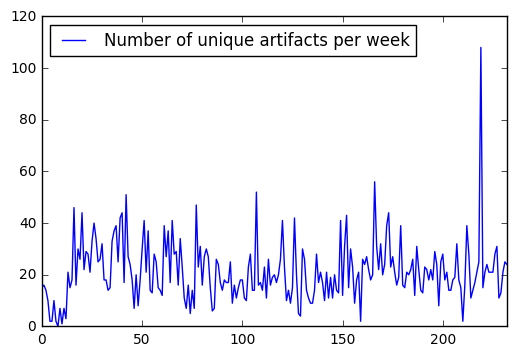

In [260]:
artifacts = getAllSetOfArtifacts('/Users/totucuong-standard/Projects/wikisocial/data/wtp-networksv2/wtpnetwork_timestamp.csv_', numberOfWeeks=233)
nArtPerWeek = []
for i in range(0, len(artifacts)):
    nArtPerWeek.append(len(artifacts[i]))

# artifactData = {}
# artifactData['#artifacts'] = nArtPerWeek
import pandas as pd
import numpy as np
df = pd.DataFrame(data=nArtPerWeek, columns=['Number of unique artifacts per week'])
df.plot()
plt.show()




# What kind of Property or Items are there?

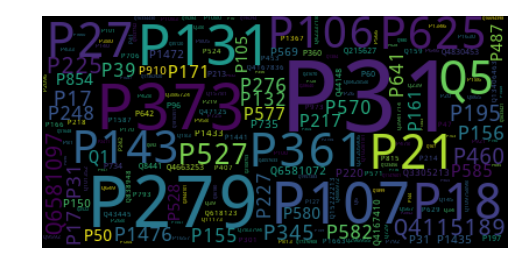

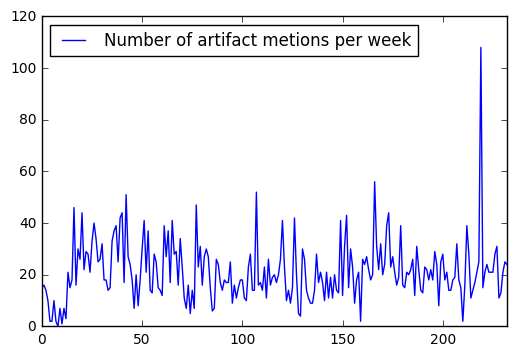

In [263]:
def getListOfArtifacts(pathToDataFile):
    f = open(pathToDataFile, 'r')
    artifacts = []
    for l in f:
        items = l.split(";")
        if len(items) > 4:
            for i in range(3, len(items)-1):
                if items[i].startswith('P') or items[i].startswith('Q'):  # this is to remove wrong-formatted artifacts. Need to fix generating code.
                    artifacts.append(items[i])
    return artifacts

def getAllListOfArtifacts(filePrefix, numberOfWeeks):
    result = []
    for i in range(0, numberOfWeeks):
        result.append(getSetOfArtifacts(filePrefix + str(i)))
    return result

artifacts = getAllListOfArtifacts('/Users/totucuong-standard/Projects/wikisocial/data/wtp-networksv2/wtpnetwork_timestamp.csv_', numberOfWeeks=233)


from os import path
from wordcloud import WordCloud


# Read the whole text.
# text = open('/Users/totucuong-standard/Projects/wikisocial/data/wtp-networksv2/wtpnetwork_timestamp.csv_0').read()
text = ''
for w in artifacts:
    for a in w:
        text = text + a
        text = text + ' '

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# # lower max_font_size
# wordcloud = WordCloud(max_font_size=40).generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
plt.show()


nArtPerWeek = []
for i in range(0, len(artifacts)):
    nArtPerWeek.append(len(artifacts[i]))
# print(artifacts)
# artifactData = {}
# artifactData['#artifacts'] = nArtPerWeek
import pandas as pd
import numpy as np
df = pd.DataFrame(data=nArtPerWeek, columns=['Number of artifact metions per week'])
df.plot()
plt.show()

- P31: Wikipedia disambiguation page
edit (https://www.wikidata.org/wiki/Q2122653)